# $$ Sarsa (\lambda)$$

## Imports

In [1]:
# imports from libs
import sys
import numpy as np
import math
import random
import gym
import gym_maze
import os
from collections import defaultdict


# imports from project
from utils.plotting import plot_line_graphs_overlayed
from utils.file_management import create_folder_structure
from utils.file_management import save_nparray_to_folder

## Setting Saving Directory

In [2]:
cwd = os.getcwd()
SAVING_RESULTS_FODLER = os.path.join(cwd,"results","SARSA_LAMBDA")
SAVING_RESULTS_FODLER

'c:\\Users\\msasso\\Desktop\\mazze-portal-rl-unicamp\\results\\SARSA_LAMBDA'

## Constants

In [3]:
# Initialize the "maze" environment
env = gym.make("maze-v0")

'''
Defining the environment related constants
'''
# Number of discrete states (bucket) per state dimension
MAZE_SIZE = tuple((env.observation_space.high + np.ones(env.observation_space.shape)).astype(int))
NUM_BUCKETS = MAZE_SIZE  # one bucket per grid

# Number of discrete actions
NUM_ACTIONS = env.action_space.n  # ["N", "S", "E", "W"]
# Bounds for each discrete state
STATE_BOUNDS = list(zip(env.observation_space.low, env.observation_space.high))

'''
Learning related constants
'''
MIN_EXPLORE_RATE = 0.001
DECAY_FACTOR = np.prod(MAZE_SIZE, dtype=float) / 10.0

'''
Defining the simulation related constants
'''
NUM_EPISODES = 1000
MAX_T = np.prod(MAZE_SIZE, dtype=int) * 100
STREAK_TO_END = 100
SOLVED_T = np.prod(MAZE_SIZE, dtype=int)
RENDER_MAZE = False
ENABLE_RECORDING = False

'''
Sarsa Lambda Related Constants
'''

DISCOUNT_FACTOR = 0.99
LEARNING_RATE = 0.01
EPSILON = 1
EPSILON_DECAY = 0.999
LAMBDA_VAL_TRACE_DECAY_LIST = [0,0.2,0.4,0.6,0.8,1.0]


'''
CREATING RESULTS SAVING FOLDERS
'''
SAVING_RESULTS_IMAGE_FODLER = os.path.join(SAVING_RESULTS_FODLER,"images")
SAVING_RESULTS_VIDEO_FODLER = os.path.join(SAVING_RESULTS_FODLER,"videos")
SAVING_RESULTS_ARRAY_FODLER = os.path.join(SAVING_RESULTS_FODLER,"arrays")
create_folder_structure(SAVING_RESULTS_IMAGE_FODLER)
create_folder_structure(SAVING_RESULTS_VIDEO_FODLER)
create_folder_structure(SAVING_RESULTS_ARRAY_FODLER)

'''
ENABLE RECORDING
'''
if ENABLE_RECORDING:
    env = gym.wrappers.Monitor(env,SAVING_RESULTS_VIDEO_FODLER, force=True)
    
    

pygame 2.0.1 (SDL 2.0.14, Python 3.7.4)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Algorithm Simulation

In [4]:
def simulate(discount_factor:float=0.99,
            learning_rate:float=0.01,
            epsilon:float= 1,
            epsilon_decay:float= 0.999,
            trace_decay:int= 0):


    """Simulate Sarsa Algorythim .

    Args:
        discount_factor (float): gamma.
        epsilon (float): gamma.
        epsilon_decay (float): gamma.
        trace_decay (float): gamma.


    Returns:
        np.array(reward_episode_list): Numpy array with the episodes rewards
        np.array(explore_rate_episode_list): Numpy array with the episodes explore rates
        np.array(learning_rate_episode_list): Numpy array with the episodes learning rates
        np.array(num_streaks_episode_list): Numpy array with the episodes number of mazze completions
        np.array(length_episode_list): Numpy array with the episodes lengths
    """
    
    #creating episodes results lists
    
    reward_episode_list = []
    explore_rate_episode_list = []
    num_streaks_episode_list = []
    length_episode_list = []


    # Instantiating the learning related parameters
    #learning_rate = get_learning_rate(0) # alpha
    explore_rate = get_explore_rate(0)
     
    # Render tha maze
    env.render()
    
    #q_table # inicializar ela aqui.
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    

    #Initializain num streaks
    num_streaks= 0

    for episode in range(NUM_EPISODES):

 
        # Reset the environment
        obv = env.reset()
        
        # initialize Reward
        total_reward = 0
        
        # initialize episolon decay
        epsilon *= epsilon_decay

        # E(S,A) = 0
        E = defaultdict(lambda: np.zeros(env.action_space.n))
        
        # Initialize state
        state = state_to_bucket(obv)
        
        # initialize action    # VERIFICAR SE SEGUE A POLITICA   
        action = epsilon_greedy_police(state, explore_rate, Q)
        
        for t in range(MAX_T):

            # Select an action
            next_action = epsilon_greedy_police(state, explore_rate, Q)
            
            # execute the action
            obv, reward, done, _ = env.step(action)

            # Observe the result
            next_state = state_to_bucket(obv)
            total_reward += reward
            
            # current_q
            current_q = Q[state][action] 
            
            # next_q
            next_q = Q[next_state][next_action]
            
            # TD = r + gamma * Q(S', A') - Q(S,A)
            # TD = sigma
            TD = reward + (discount_factor * (next_q) - current_q )
            
            # E(S,A) - E(S,A) + 1
            E[state][action] += 1
            
            #For all s E S, a E A(s)
            for s, _ in Q.items():
                Q[s][:] += learning_rate * TD * E[s][:]
                E[s][:] *= trace_decay * discount_factor


            #S - S'
            state = next_state
            
            # A - A'
            action = next_action
            

            # Render tha maze
            if RENDER_MAZE:
                env.render()

            if env.is_game_over():
                sys.exit()

            if done:
                print(f"Episode {episode} finished after {t} time steps with total reward = {total_reward} (streak {num_streaks}).")

                if t <= SOLVED_T:
                    num_streaks += 1
                else:
                    num_streaks = 0
                break

            elif t >= MAX_T - 1:
                print(f"Episode {episode} timed out at {t} with total reward = {total_reward}.")

        

        # Appending Episode values to the list
        reward_episode_list.append(total_reward)
        explore_rate_episode_list.append(explore_rate)
        num_streaks_episode_list.append(num_streaks)
        length_episode_list.append(t)

        # It's considered done when it's solved over 120 times consecutively
        if num_streaks > STREAK_TO_END:
            break

        # Update parameters
        explore_rate = get_explore_rate(episode)


    return (np.array(reward_episode_list),
            np.array(explore_rate_episode_list),
            np.array(num_streaks_episode_list),
            np.array(length_episode_list))

## Epsilon Greed Exploration

In [5]:
def epsilon_greedy_police(state, explore_rate, q_table):
    # Select a random action
    if random.random() < explore_rate:
        action = env.action_space.sample()
    # Select the action with the highest q
    else:
        action = int(np.argmax(q_table[state]))
    return action

## Updating EXPLORE_RATE and LEARNING_RATE

In [6]:
def get_explore_rate(t):
    return max(MIN_EXPLORE_RATE, min(0.8, 1.0 - math.log10((t+1)/DECAY_FACTOR)))

## Function that returns the actual state

In [7]:
def state_to_bucket(state):
    bucket_indice = []
    for i in range(len(state)):
        if state[i] <= STATE_BOUNDS[i][0]:
            bucket_index = 0
        elif state[i] >= STATE_BOUNDS[i][1]:
            bucket_index = NUM_BUCKETS[i] - 1
        else:
            # Mapping the state bounds to the bucket array
            bound_width = STATE_BOUNDS[i][1] - STATE_BOUNDS[i][0]
            offset = (NUM_BUCKETS[i]-1)*STATE_BOUNDS[i][0]/bound_width
            scaling = (NUM_BUCKETS[i]-1)/bound_width
            bucket_index = int(round(scaling*state[i] - offset))
        bucket_indice.append(bucket_index)
    return tuple(bucket_indice)

## Running

 = 0.8719999999999999 (streak 1).
Episode 595 finished after 20 time steps with total reward = 0.9199999999999999 (streak 0).
Episode 596 finished after 46 time steps with total reward = 0.8159999999999998 (streak 1).
Episode 597 finished after 22 time steps with total reward = 0.9119999999999999 (streak 0).
Episode 598 finished after 22 time steps with total reward = 0.9119999999999999 (streak 1).
Episode 599 finished after 34 time steps with total reward = 0.8639999999999999 (streak 2).
Episode 600 finished after 41 time steps with total reward = 0.8359999999999999 (streak 0).
Episode 601 finished after 31 time steps with total reward = 0.8759999999999999 (streak 0).
Episode 602 finished after 22 time steps with total reward = 0.9119999999999999 (streak 0).
Episode 603 finished after 26 time steps with total reward = 0.8959999999999999 (streak 1).
Episode 604 finished after 28 time steps with total reward = 0.8879999999999999 (streak 0).
Episode 605 finished after 36 time steps with 

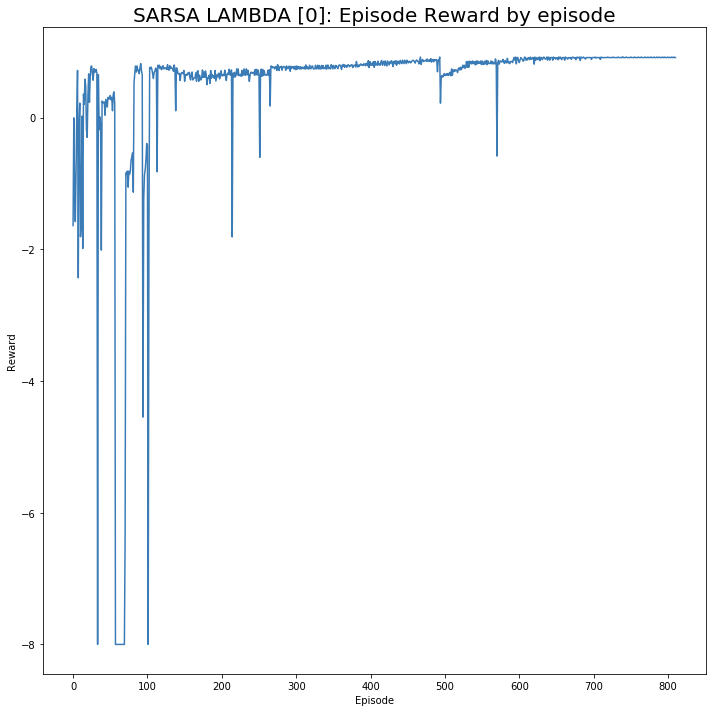

[Errno 2] No such file or directory: 'c:\\Users\\msasso\\Desktop\\mazze-portal-rl-unicamp\\results\\SARSA_LAMBDA\\images\\0\\reward_episode.png'


<Figure size 432x288 with 0 Axes>

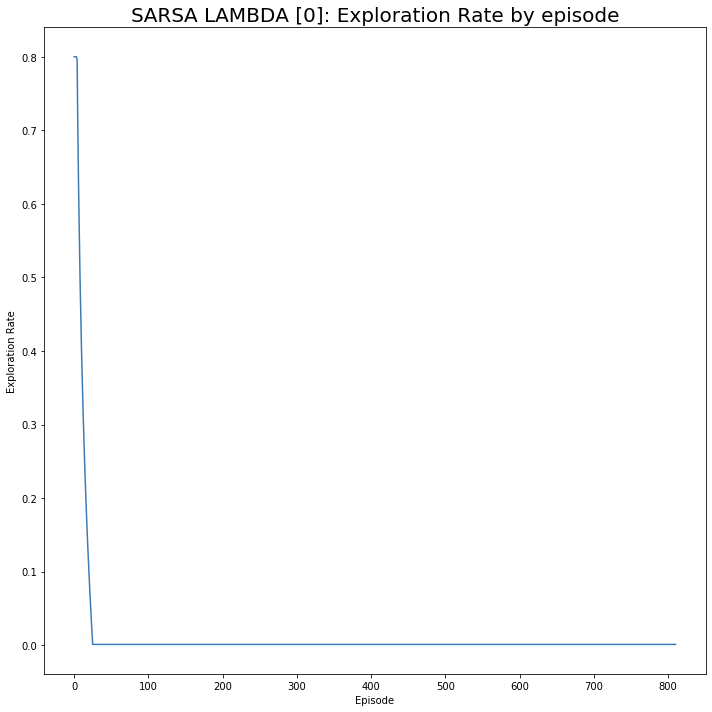

[Errno 2] No such file or directory: 'c:\\Users\\msasso\\Desktop\\mazze-portal-rl-unicamp\\results\\SARSA_LAMBDA\\images\\0\\explore_rate_episode.png'


<Figure size 432x288 with 0 Axes>

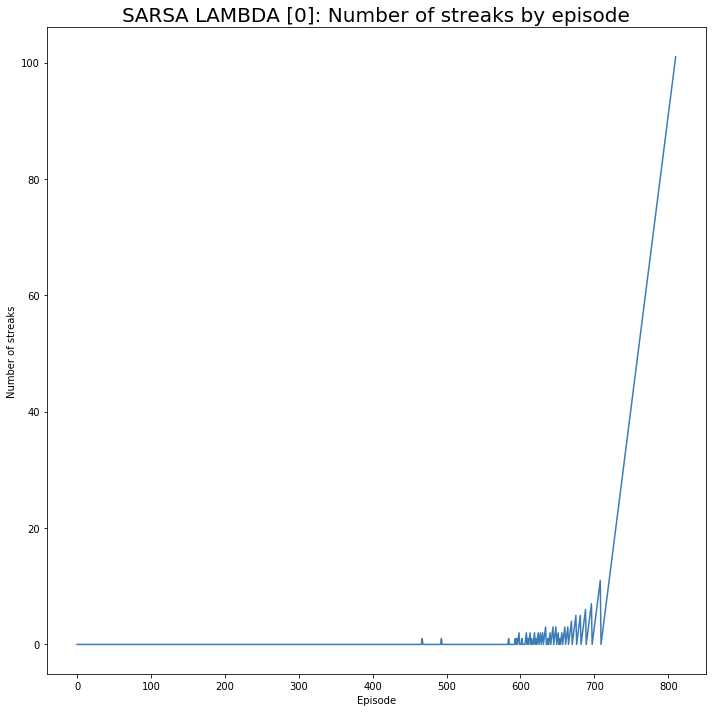

[Errno 2] No such file or directory: 'c:\\Users\\msasso\\Desktop\\mazze-portal-rl-unicamp\\results\\SARSA_LAMBDA\\images\\0\\num_streaks_episode.png'


<Figure size 432x288 with 0 Axes>

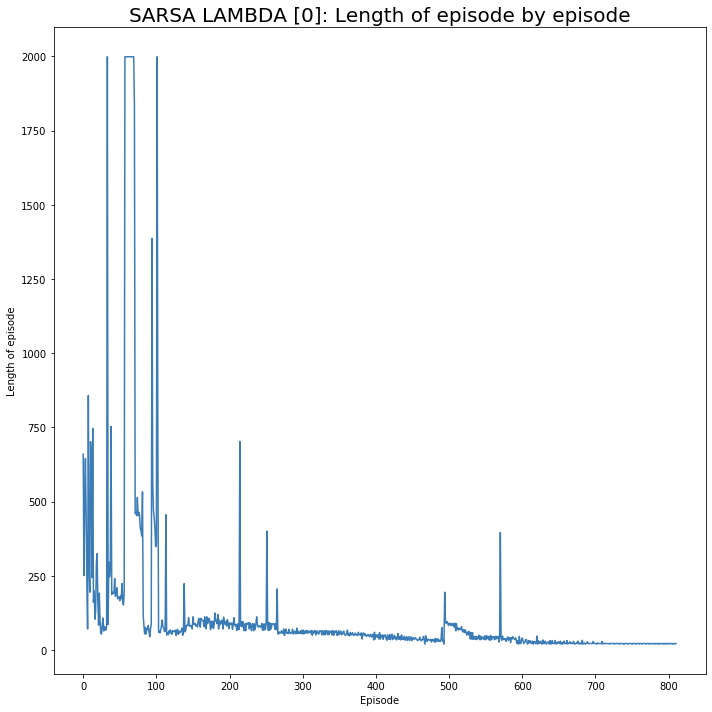

5 (streak 0).
Episode 92 finished after 133 time steps with total reward = 0.46799999999999964 (streak 0).
Episode 93 finished after 112 time steps with total reward = 0.5519999999999996 (streak 0).
Episode 94 finished after 152 time steps with total reward = 0.39199999999999957 (streak 0).
Episode 95 finished after 126 time steps with total reward = 0.49599999999999966 (streak 0).
Episode 96 finished after 107 time steps with total reward = 0.5719999999999996 (streak 0).
Episode 97 finished after 124 time steps with total reward = 0.5039999999999996 (streak 0).
Episode 98 finished after 101 time steps with total reward = 0.5959999999999996 (streak 0).
Episode 99 finished after 145 time steps with total reward = 0.4199999999999996 (streak 0).
Episode 100 finished after 130 time steps with total reward = 0.47999999999999965 (streak 0).
Episode 101 finished after 94 time steps with total reward = 0.6239999999999997 (streak 0).
Episode 102 finished after 112 time steps with total reward =

<Figure size 432x288 with 0 Axes>

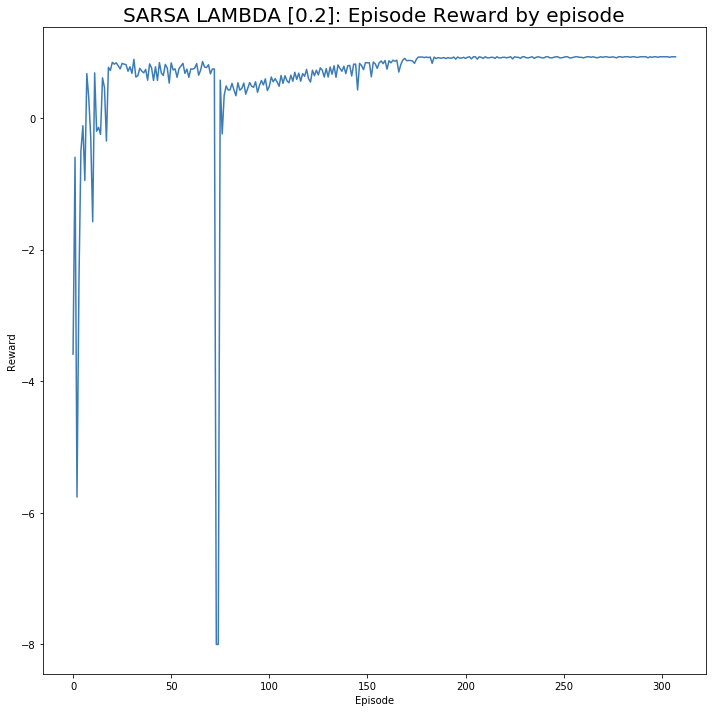

[Errno 2] No such file or directory: 'c:\\Users\\msasso\\Desktop\\mazze-portal-rl-unicamp\\results\\SARSA_LAMBDA\\images\\0.2\\reward_episode.png'


<Figure size 432x288 with 0 Axes>

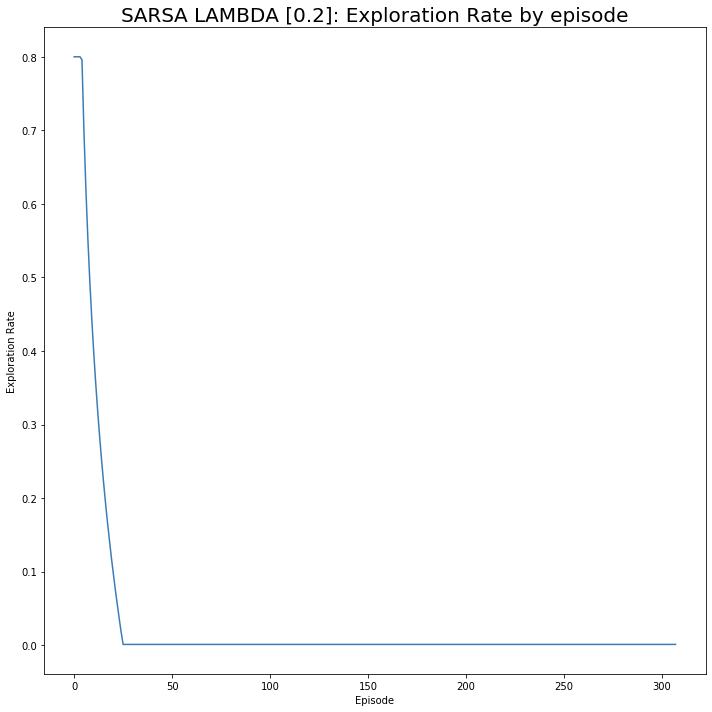

[Errno 2] No such file or directory: 'c:\\Users\\msasso\\Desktop\\mazze-portal-rl-unicamp\\results\\SARSA_LAMBDA\\images\\0.2\\explore_rate_episode.png'


<Figure size 432x288 with 0 Axes>

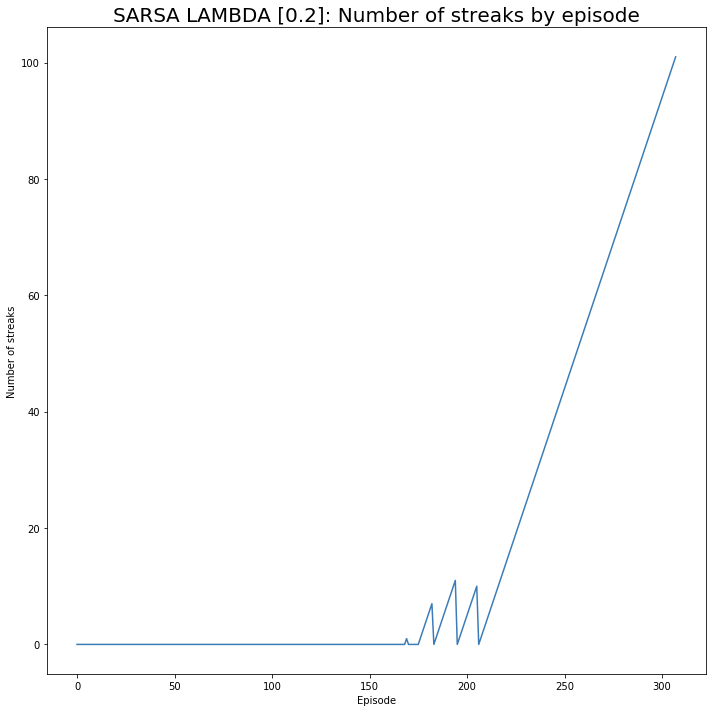

[Errno 2] No such file or directory: 'c:\\Users\\msasso\\Desktop\\mazze-portal-rl-unicamp\\results\\SARSA_LAMBDA\\images\\0.2\\num_streaks_episode.png'


<Figure size 432x288 with 0 Axes>

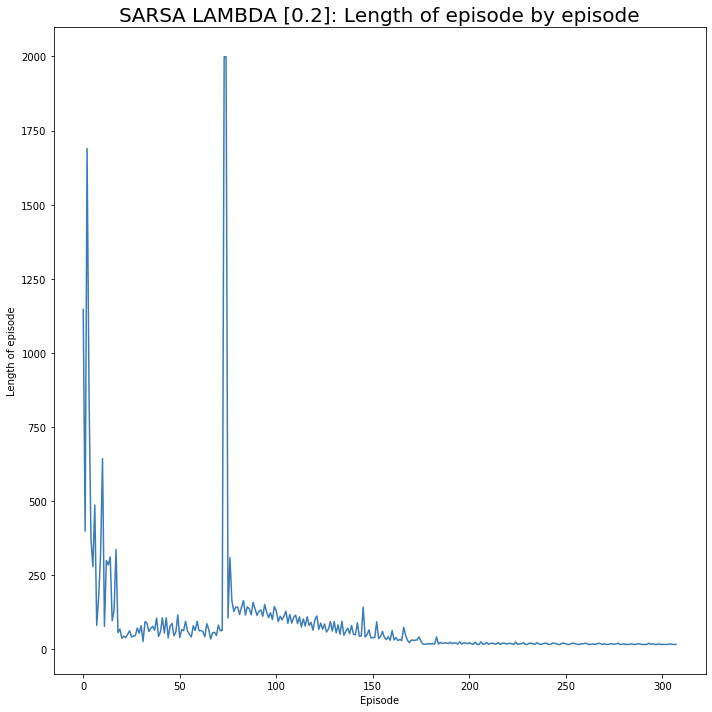

9999999999 (streak 9).
Episode 260 finished after 19 time steps with total reward = 0.9239999999999999 (streak 10).
Episode 261 finished after 23 time steps with total reward = 0.9079999999999999 (streak 11).
Episode 262 finished after 21 time steps with total reward = 0.9159999999999999 (streak 12).
Episode 263 finished after 19 time steps with total reward = 0.9239999999999999 (streak 13).
Episode 264 finished after 19 time steps with total reward = 0.9239999999999999 (streak 14).
Episode 265 finished after 23 time steps with total reward = 0.9079999999999999 (streak 15).
Episode 266 finished after 21 time steps with total reward = 0.9159999999999999 (streak 16).
Episode 267 finished after 19 time steps with total reward = 0.9239999999999999 (streak 17).
Episode 268 finished after 19 time steps with total reward = 0.9239999999999999 (streak 18).
Episode 269 finished after 19 time steps with total reward = 0.9239999999999999 (streak 19).
Episode 270 finished after 25 time steps with t

<Figure size 432x288 with 0 Axes>

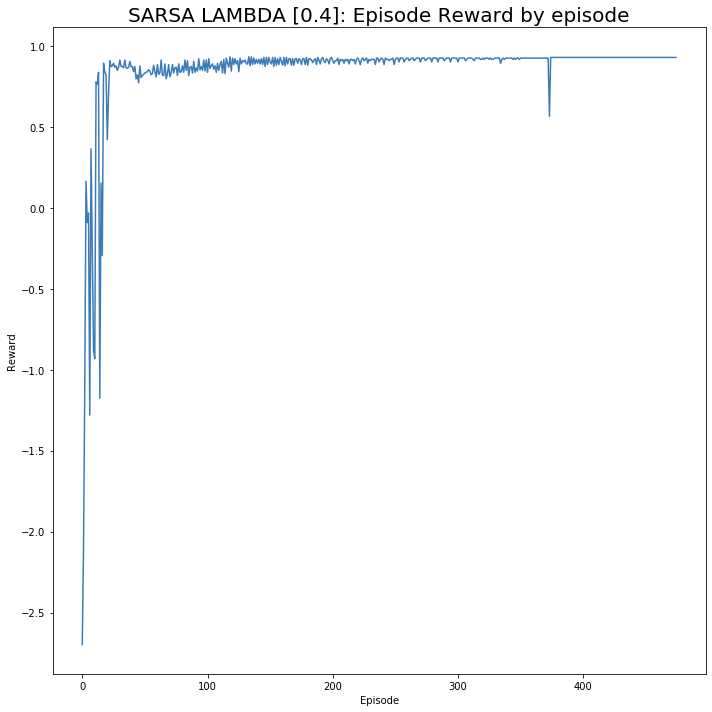

[Errno 2] No such file or directory: 'c:\\Users\\msasso\\Desktop\\mazze-portal-rl-unicamp\\results\\SARSA_LAMBDA\\images\\0.4\\reward_episode.png'


<Figure size 432x288 with 0 Axes>

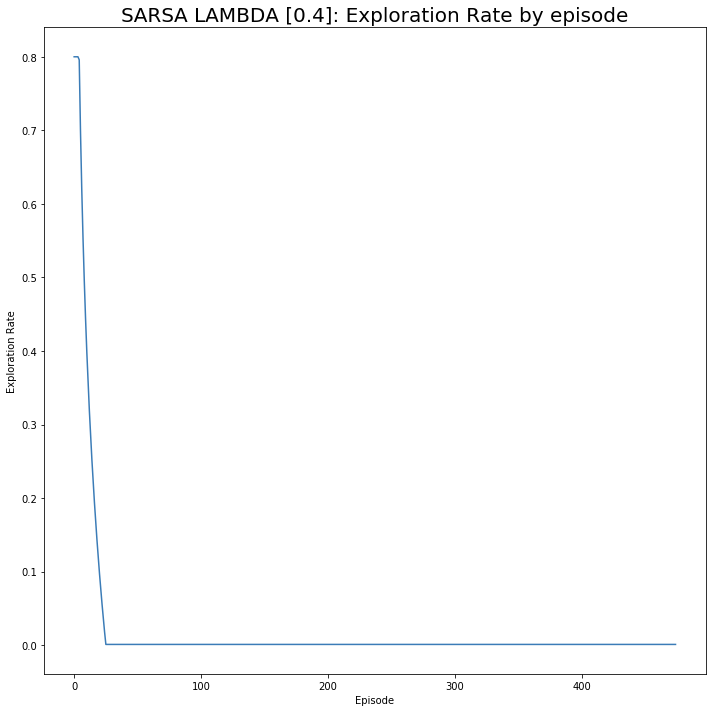

[Errno 2] No such file or directory: 'c:\\Users\\msasso\\Desktop\\mazze-portal-rl-unicamp\\results\\SARSA_LAMBDA\\images\\0.4\\explore_rate_episode.png'


<Figure size 432x288 with 0 Axes>

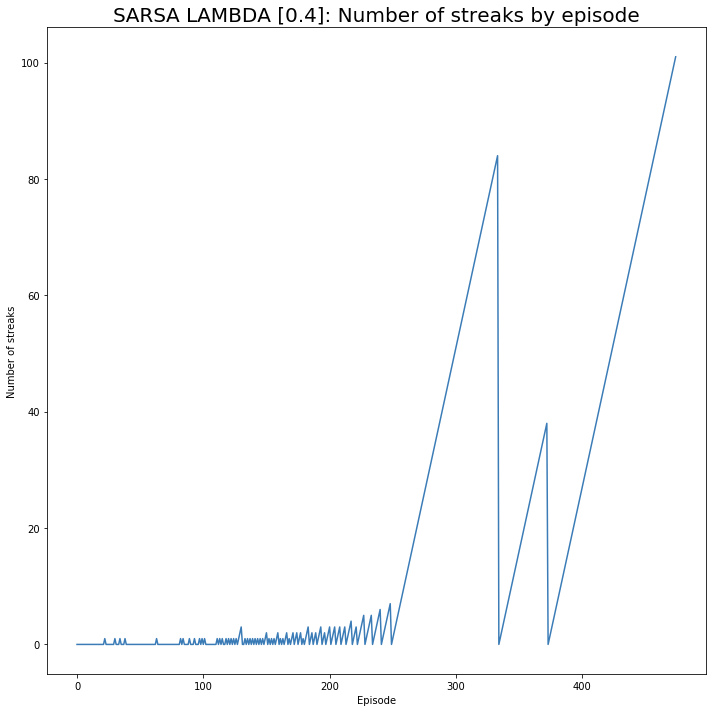

[Errno 2] No such file or directory: 'c:\\Users\\msasso\\Desktop\\mazze-portal-rl-unicamp\\results\\SARSA_LAMBDA\\images\\0.4\\num_streaks_episode.png'


<Figure size 432x288 with 0 Axes>

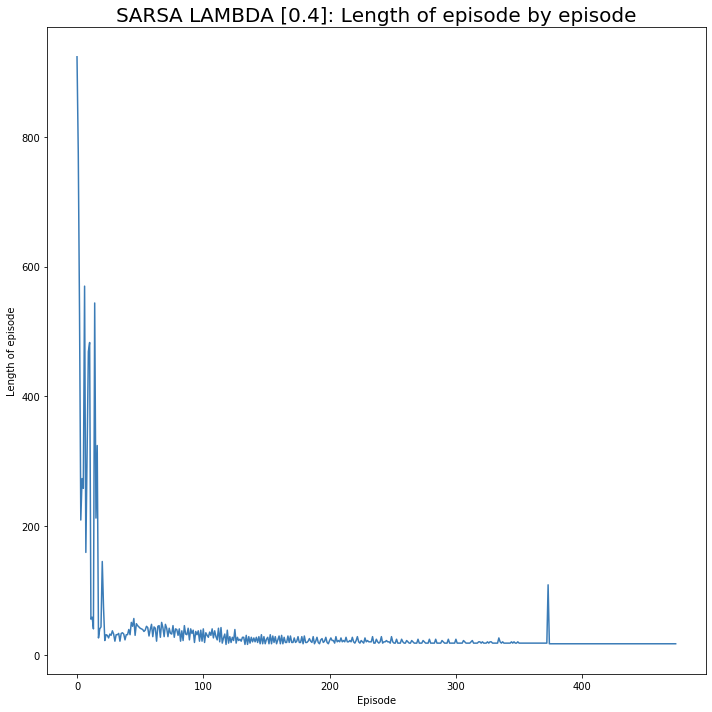

[Errno 2] No such file or directory: 'c:\\Users\\msasso\\Desktop\\mazze-portal-rl-unicamp\\results\\SARSA_LAMBDA\\images\\0.4\\length_episode.png'
================ Evaluating for LAMBDA = 0.6

Episode 0 finished after 325 time steps with total reward = -0.30000000000000093 (streak 0).
Episode 1 finished after 96 time steps with total reward = 0.6159999999999997 (streak 0).
Episode 2 finished after 519 time steps with total reward = -1.0760000000000014 (streak 0).
Episode 3 finished after 230 time steps with total reward = 0.0799999999999993 (streak 0).
Episode 4 finished after 334 time steps with total reward = -0.33600000000000096 (streak 0).
Episode 5 finished after 336 time steps with total reward = -0.34400000000000097 (streak 0).
Episode 6 finished after 141 time steps with total reward = 0.4359999999999996 (streak 0).
Episode 7 finished after 414 time steps with total reward = -0.6560000000000012 (streak 0).
Episode 8 finished after 366 time steps with total reward = -0.464000000

<Figure size 432x288 with 0 Axes>

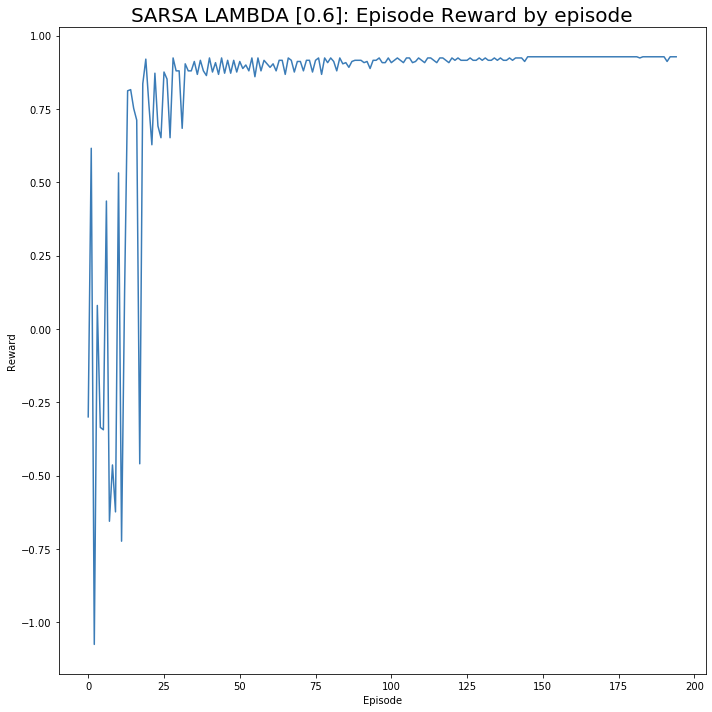

[Errno 2] No such file or directory: 'c:\\Users\\msasso\\Desktop\\mazze-portal-rl-unicamp\\results\\SARSA_LAMBDA\\images\\0.6\\reward_episode.png'


<Figure size 432x288 with 0 Axes>

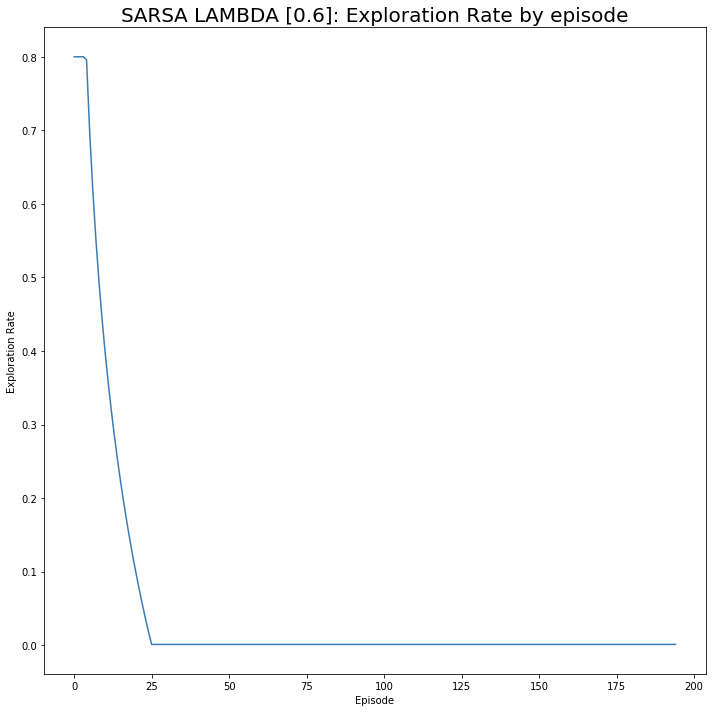

[Errno 2] No such file or directory: 'c:\\Users\\msasso\\Desktop\\mazze-portal-rl-unicamp\\results\\SARSA_LAMBDA\\images\\0.6\\explore_rate_episode.png'


<Figure size 432x288 with 0 Axes>

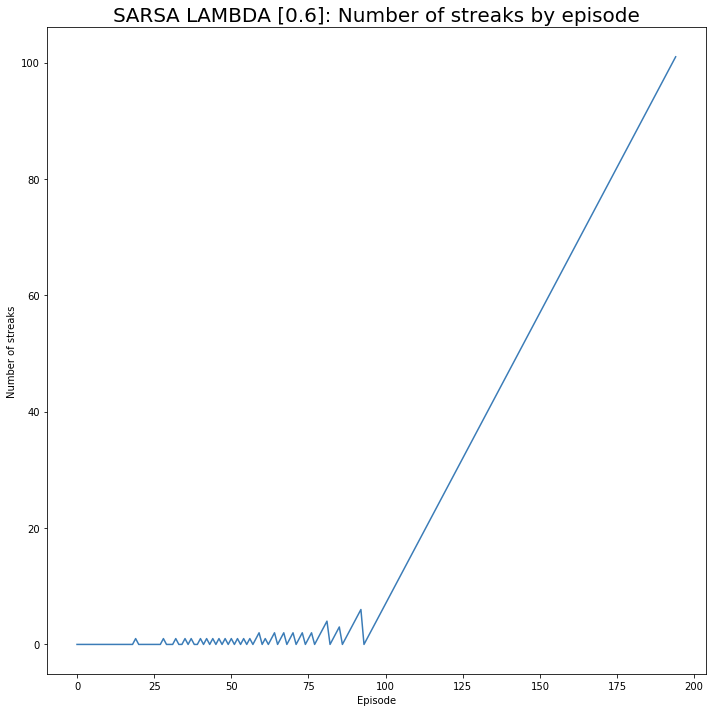

[Errno 2] No such file or directory: 'c:\\Users\\msasso\\Desktop\\mazze-portal-rl-unicamp\\results\\SARSA_LAMBDA\\images\\0.6\\num_streaks_episode.png'


<Figure size 432x288 with 0 Axes>

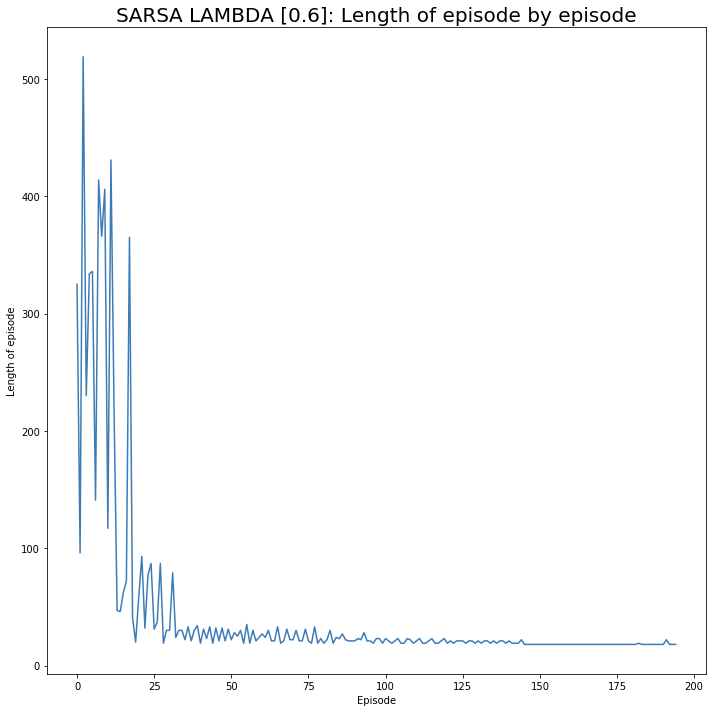

[Errno 2] No such file or directory: 'c:\\Users\\msasso\\Desktop\\mazze-portal-rl-unicamp\\results\\SARSA_LAMBDA\\images\\0.6\\length_episode.png'
================ Evaluating for LAMBDA = 0.8

Episode 0 finished after 482 time steps with total reward = -0.9280000000000015 (streak 0).
Episode 1 finished after 78 time steps with total reward = 0.6879999999999997 (streak 0).
Episode 2 finished after 453 time steps with total reward = -0.8120000000000014 (streak 0).
Episode 3 finished after 300 time steps with total reward = -0.20000000000000084 (streak 0).
Episode 4 finished after 542 time steps with total reward = -1.1680000000000015 (streak 0).
Episode 5 finished after 166 time steps with total reward = 0.3359999999999995 (streak 0).
Episode 6 finished after 93 time steps with total reward = 0.6279999999999997 (streak 0).
Episode 7 finished after 108 time steps with total reward = 0.5679999999999996 (streak 0).
Episode 8 finished after 242 time steps with total reward = 0.03199999999999

<Figure size 432x288 with 0 Axes>

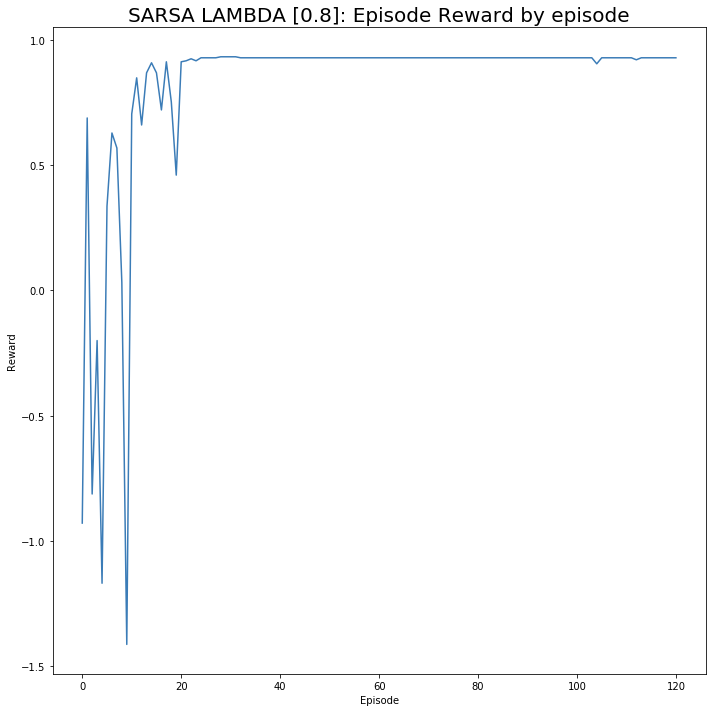

[Errno 2] No such file or directory: 'c:\\Users\\msasso\\Desktop\\mazze-portal-rl-unicamp\\results\\SARSA_LAMBDA\\images\\0.8\\reward_episode.png'


<Figure size 432x288 with 0 Axes>

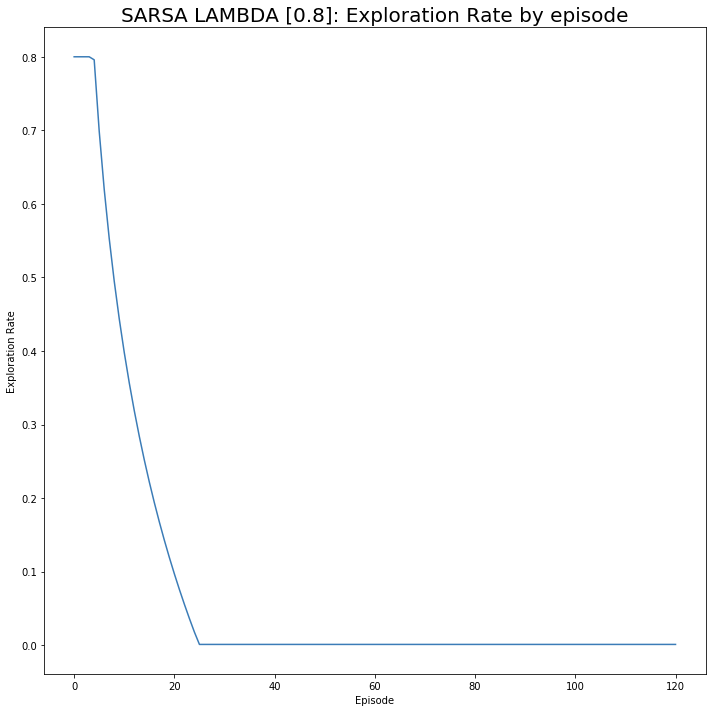

[Errno 2] No such file or directory: 'c:\\Users\\msasso\\Desktop\\mazze-portal-rl-unicamp\\results\\SARSA_LAMBDA\\images\\0.8\\explore_rate_episode.png'


<Figure size 432x288 with 0 Axes>

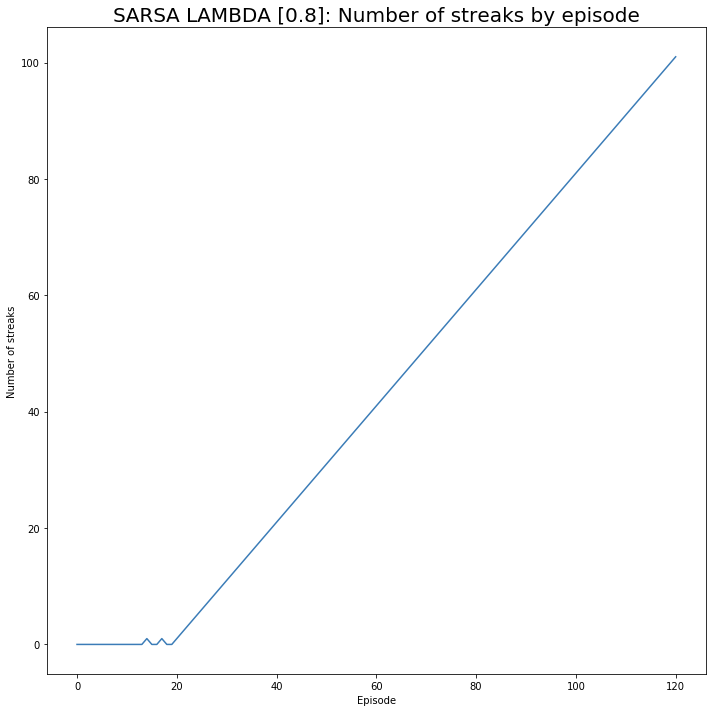

[Errno 2] No such file or directory: 'c:\\Users\\msasso\\Desktop\\mazze-portal-rl-unicamp\\results\\SARSA_LAMBDA\\images\\0.8\\num_streaks_episode.png'


<Figure size 432x288 with 0 Axes>

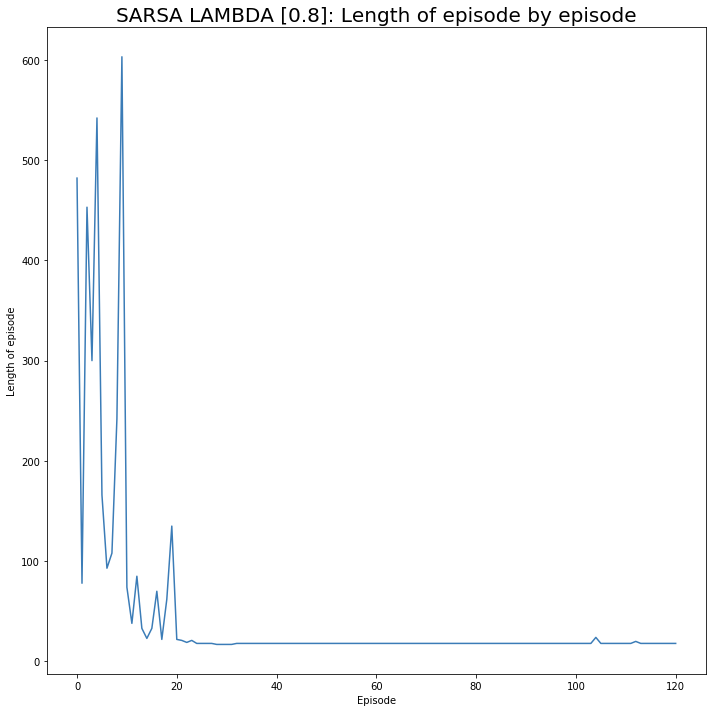

[Errno 2] No such file or directory: 'c:\\Users\\msasso\\Desktop\\mazze-portal-rl-unicamp\\results\\SARSA_LAMBDA\\images\\0.8\\length_episode.png'
================ Evaluating for LAMBDA = 1.0

Episode 0 finished after 252 time steps with total reward = -0.008000000000000673 (streak 0).
Episode 1 finished after 269 time steps with total reward = -0.07600000000000073 (streak 0).
Episode 2 finished after 162 time steps with total reward = 0.35199999999999954 (streak 0).
Episode 3 finished after 311 time steps with total reward = -0.24400000000000088 (streak 0).
Episode 4 finished after 199 time steps with total reward = 0.2039999999999994 (streak 0).
Episode 5 finished after 60 time steps with total reward = 0.7599999999999998 (streak 0).
Episode 6 finished after 34 time steps with total reward = 0.8639999999999999 (streak 0).
Episode 7 finished after 44 time steps with total reward = 0.8239999999999998 (streak 0).
Episode 8 finished after 53 time steps with total reward = 0.7879999999999

<Figure size 432x288 with 0 Axes>

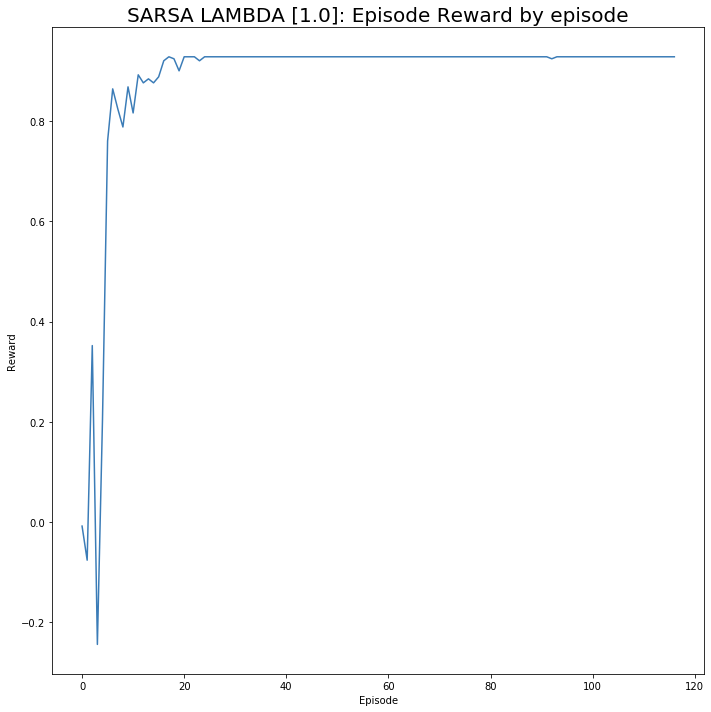

[Errno 2] No such file or directory: 'c:\\Users\\msasso\\Desktop\\mazze-portal-rl-unicamp\\results\\SARSA_LAMBDA\\images\\1.0\\reward_episode.png'


<Figure size 432x288 with 0 Axes>

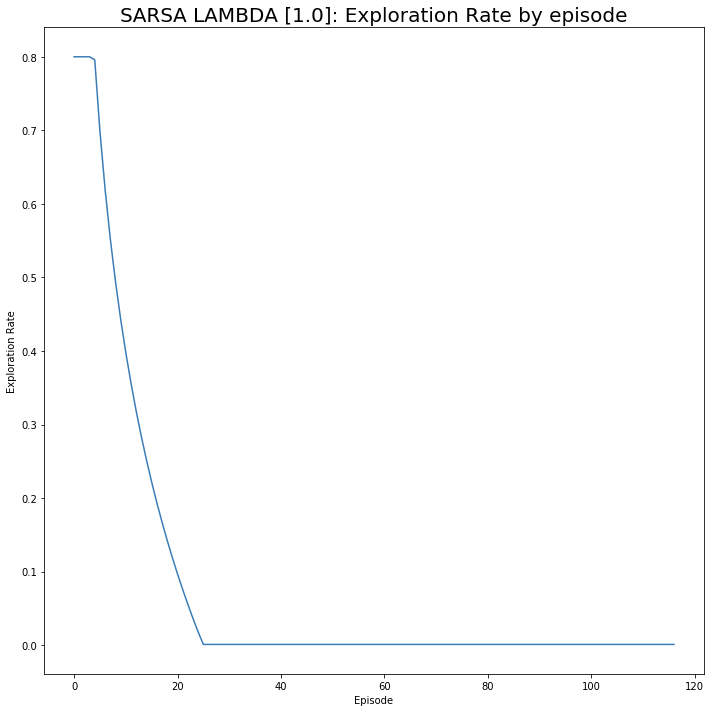

[Errno 2] No such file or directory: 'c:\\Users\\msasso\\Desktop\\mazze-portal-rl-unicamp\\results\\SARSA_LAMBDA\\images\\1.0\\explore_rate_episode.png'


<Figure size 432x288 with 0 Axes>

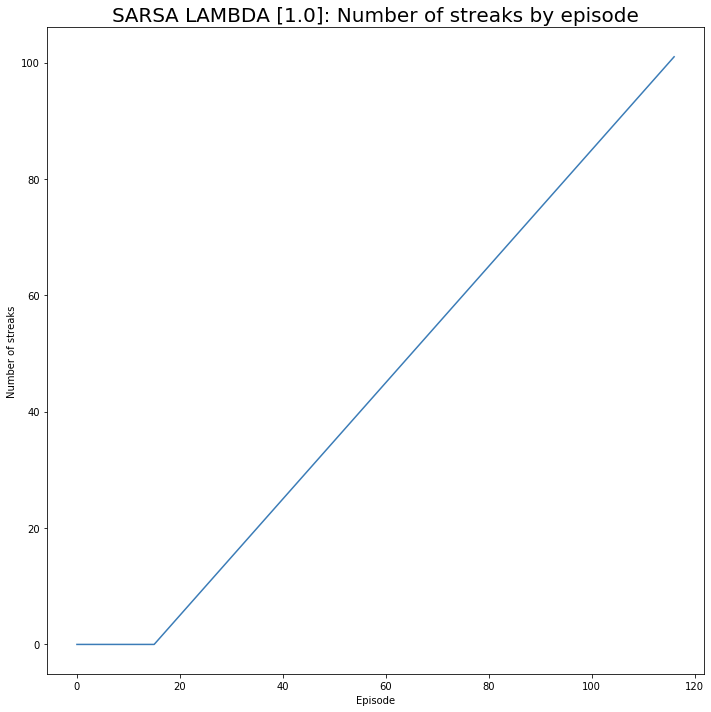

[Errno 2] No such file or directory: 'c:\\Users\\msasso\\Desktop\\mazze-portal-rl-unicamp\\results\\SARSA_LAMBDA\\images\\1.0\\num_streaks_episode.png'


<Figure size 432x288 with 0 Axes>

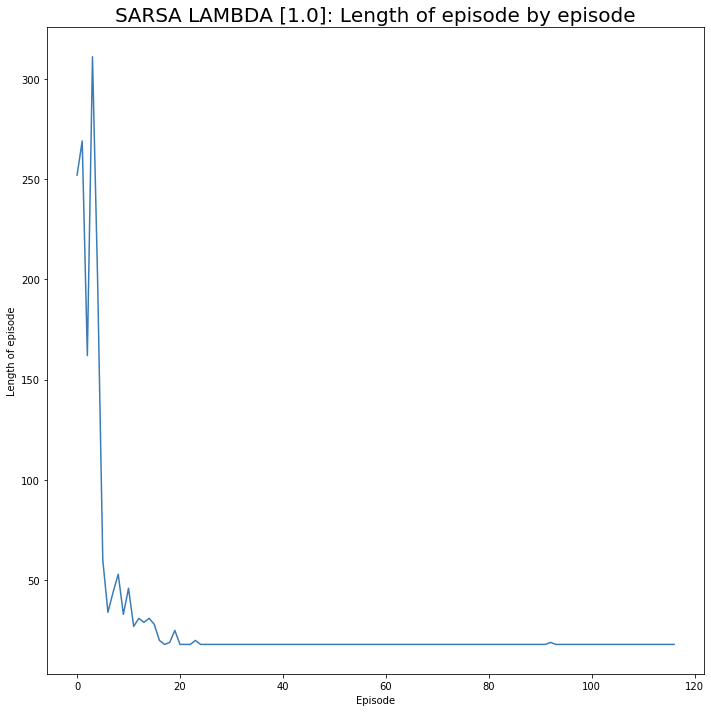

[Errno 2] No such file or directory: 'c:\\Users\\msasso\\Desktop\\mazze-portal-rl-unicamp\\results\\SARSA_LAMBDA\\images\\1.0\\length_episode.png'


<Figure size 432x288 with 0 Axes>

In [8]:

reward_episode_array_list = []
explore_rate_episode_array_list = []
num_streaks_episode_array_list = []
length_episode_array_list = []

for i in range(len(LAMBDA_VAL_TRACE_DECAY_LIST)):
        SAVING_RESULTS_IMAGE_FODLER_LAMBDA_DECAY = os.path.join(SAVING_RESULTS_IMAGE_FODLER,str(LAMBDA_VAL_TRACE_DECAY_LIST[i]))

        
        LAMBDA_VAL_TRACE_DECAY = LAMBDA_VAL_TRACE_DECAY_LIST[i]
        print(f"================ Evaluating for LAMBDA = {LAMBDA_VAL_TRACE_DECAY}\n")

        reward_episode_array,explore_rate_episode_array,num_streaks_episode_array,length_episode_array = \
        simulate(discount_factor=DISCOUNT_FACTOR,
                learning_rate=LEARNING_RATE,
                epsilon=EPSILON,
                epsilon_decay=EPSILON_DECAY,
                trace_decay=LAMBDA_VAL_TRACE_DECAY)

        
        reward_episode_array_list.append(reward_episode_array)
        explore_rate_episode_array_list.append(explore_rate_episode_array)
        num_streaks_episode_array_list.append(num_streaks_episode_array)
        length_episode_array_list.append(length_episode_array)


        
        graph_saving_path = os.path.join(SAVING_RESULTS_IMAGE_FODLER_LAMBDA_DECAY,"reward_episode")
        plot_line_graphs_overlayed(x_list = [range(NUM_EPISODES)[:len(num_streaks_episode_array)]],
                            y_list = [reward_episode_array],
                            x_axe_name="Episode", 
                            y_axe_name="Reward",
                            legends = ["None_Marker"],
                            title = f"SARSA LAMBDA [{LAMBDA_VAL_TRACE_DECAY}]: Episode Reward by episode" ,
                                graph_saving_path = graph_saving_path)


        graph_saving_path = os.path.join(SAVING_RESULTS_IMAGE_FODLER_LAMBDA_DECAY,"explore_rate_episode")
        plot_line_graphs_overlayed(x_list = [range(NUM_EPISODES)[:len(num_streaks_episode_array)]],
                                y_list = [explore_rate_episode_array],
                                x_axe_name="Episode", 
                                y_axe_name="Exploration Rate",
                                legends = ["None_Marker"],
                                title = f"SARSA LAMBDA [{LAMBDA_VAL_TRACE_DECAY}]: Exploration Rate by episode" ,
                                graph_saving_path = graph_saving_path)


        graph_saving_path = os.path.join(SAVING_RESULTS_IMAGE_FODLER_LAMBDA_DECAY,"num_streaks_episode")
        plot_line_graphs_overlayed(x_list =[range(NUM_EPISODES)[:len(num_streaks_episode_array)]],
                                y_list = [num_streaks_episode_array],
                                x_axe_name="Episode", 
                                y_axe_name="Number of streaks",
                                legends = ["None_Marker"],
                                title = f"SARSA LAMBDA [{LAMBDA_VAL_TRACE_DECAY}]: Number of streaks by episode" ,
                                graph_saving_path = graph_saving_path)


        graph_saving_path = os.path.join(SAVING_RESULTS_IMAGE_FODLER_LAMBDA_DECAY,"length_episode")
        plot_line_graphs_overlayed(x_list = [range(NUM_EPISODES)[:len(num_streaks_episode_array)]],
                                y_list = [length_episode_array],
                                x_axe_name="Episode", 
                                y_axe_name="Length of episode",
                                legends = ["None_Marker"],
                                title = f"SARSA LAMBDA [{LAMBDA_VAL_TRACE_DECAY}]: Length of episode by episode" ,
                                graph_saving_path = graph_saving_path)


                                                                                                        
if ENABLE_RECORDING:
        env.close()

## Saving numpy arrays from results

In [9]:
for i in range(len(LAMBDA_VAL_TRACE_DECAY_LIST)):
    LAMBDA_VAL_FOLDER = os.path.join(SAVING_RESULTS_ARRAY_FODLER,str(LAMBDA_VAL_TRACE_DECAY_LIST[i]))
    create_folder_structure(LAMBDA_VAL_FOLDER)
    save_nparray_to_folder(reward_episode_array_list[i],LAMBDA_VAL_FOLDER,"reward_episode")
    save_nparray_to_folder(explore_rate_episode_array_list[i],LAMBDA_VAL_FOLDER,"explore_rate")
    save_nparray_to_folder(num_streaks_episode_array_list[i],LAMBDA_VAL_FOLDER,"num_streaks")
    save_nparray_to_folder(length_episode_array_list[i],LAMBDA_VAL_FOLDER,"length_episode")

reward_episode Shape:  (811,)
explore_rate Shape:  (811,)
num_streaks Shape:  (811,)
length_episode Shape:  (811,)
reward_episode Shape:  (308,)
explore_rate Shape:  (308,)
num_streaks Shape:  (308,)
length_episode Shape:  (308,)
reward_episode Shape:  (475,)
explore_rate Shape:  (475,)
num_streaks Shape:  (475,)
length_episode Shape:  (475,)
reward_episode Shape:  (195,)
explore_rate Shape:  (195,)
num_streaks Shape:  (195,)
length_episode Shape:  (195,)
reward_episode Shape:  (121,)
explore_rate Shape:  (121,)
num_streaks Shape:  (121,)
length_episode Shape:  (121,)
reward_episode Shape:  (117,)
explore_rate Shape:  (117,)
num_streaks Shape:  (117,)
length_episode Shape:  (117,)


In [10]:
# graph_saving_path = os.path.join(SAVING_RESULTS_IMAGE_FODLER,"reward_episode")
# plot_line_graphs_overlayed(x_list = [range(NUM_EPISODES)[:len(num_streaks_episode_array)]],
#                             y_list = [reward_episode_array],
#                             x_axe_name="Episode", 
#                             y_axe_name="Reward",
#                             legends = ["None_Marker"],
#                             title = "Q-Learning: Episode Reward by episode" ,
#                             graph_saving_path = graph_saving_path)


# graph_saving_path = os.path.join(SAVING_RESULTS_IMAGE_FODLER,"explore_rate_episode_array")
# plot_line_graphs_overlayed(x_list = [range(NUM_EPISODES)[:len(num_streaks_episode_array)]],
#                             y_list = [explore_rate_episode_array],
#                             x_axe_name="Episode", 
#                             y_axe_name="Exploration Rate",
#                             legends = ["None_Marker"],
#                             title = "Q-Learning: Exploration Rate by episode" ,
#                             graph_saving_path = graph_saving_path)


# graph_saving_path = os.path.join(SAVING_RESULTS_IMAGE_FODLER,"learning_rate_episode_array")
# plot_line_graphs_overlayed(x_list = [range(NUM_EPISODES)[:len(num_streaks_episode_array)]],
#                             y_list = [learning_rate_episode_array],
#                             x_axe_name="Episode", 
#                             y_axe_name="Learning Rate",
#                             legends = ["None_Marker"],
#                             title = "Q-Learning: Learning Rate by episode" ,
#                             graph_saving_path = graph_saving_path)


# graph_saving_path = os.path.join(SAVING_RESULTS_IMAGE_FODLER,"num_streaks_episode_array")
# plot_line_graphs_overlayed(x_list =[range(NUM_EPISODES)[:len(num_streaks_episode_array)]],
#                             y_list = [num_streaks_episode_array],
#                             x_axe_name="Episode", 
#                             y_axe_name="Number of streaks",
#                             legends = ["None_Marker"],
#                             title = "Q-Learning: Number of streaks by episode" ,
#                             graph_saving_path = graph_saving_path)


# graph_saving_path = os.path.join(SAVING_RESULTS_IMAGE_FODLER,"length_episode_array")
# plot_line_graphs_overlayed(x_list = [range(NUM_EPISODES)[:len(num_streaks_episode_array)]],
#                             y_list = [length_episode_array],
#                             x_axe_name="Episode", 
#                             y_axe_name="Length of episode",
#                             legends = ["None_Marker"],
#                             title = "Q-Learning: Length of episode by episode" ,
#                             graph_saving_path = graph_saving_path)

In [11]:
# reward_episode_array_list = []
# explore_rate_episode_array_list = []
# learning_rate_episode_array_list = []
# num_streaks_episode_array_list = []
# length_episode_array_list = []
# for LAMBDA_VAL_TRACE_DECAY in LAMBDA_VAL_TRACE_DECAY_LIST:

#         print(f"================ Evaluating for LAMBDA = {LAMBDA_VAL_TRACE_DECAY}\n")

#         reward_episode_array,explore_rate_episode_array,learning_rate_episode_array,num_streaks_episode_array,length_episode_array = \
#         simulate(discount_factor=DISCOUNT_FACTOR,
#                 eligibility_decay=ELIGIBILITY_DECAY,
#                 epsilon=EPSILON,
#                 epsilon_decay=EPSILON_DECAY,
#                 trace_decay=LAMBDA_VAL_TRACE_DECAY)


#         reward_episode_array_list.append(reward_episode_array)
#         explore_rate_episode_array_list.append(explore_rate_episode_array)
#         learning_rate_episode_array_list.append(learning_rate_episode_array)
#         num_streaks_episode_array_list.append(num_streaks_episode_array)
#         length_episode_array_list.append(length_episode_array)

                                                                                                        
# if ENABLE_RECORDING:
#         env.close()

In [12]:
# x_list = [range(NUM_EPISODES)[:len(num_streaks_episode_array)] for num_streaks_episode_array in num_streaks_episode_array_list]
# legends = [f"Lambda {LAMBDA_VAL_TRACE_DECAY}" for LAMBDA_VAL_TRACE_DECAY in LAMBDA_VAL_TRACE_DECAY_LIST]


# graph_saving_path = os.path.join(SAVING_RESULTS_IMAGE_FODLER,"reward_episode")
# plot_line_graphs_overlayed(x_list = x_list,
#                         y_list = reward_episode_array_list,
#                         x_axe_name="Episode", 
#                         y_axe_name="Reward",
#                         legends = legends,
#                         title = "Sarsa Lambda: Episode Reward by episode" ,
#                         graph_saving_path = graph_saving_path)


# graph_saving_path = os.path.join(SAVING_RESULTS_IMAGE_FODLER,"explore_rate_episode_array")
# plot_line_graphs_overlayed(x_list = x_list,
#                         y_list = explore_rate_episode_array_list,
#                         x_axe_name="Episode", 
#                         y_axe_name="Exploration Rate",
#                         legends = legends,
#                         title = "Sarsa Lambda: Exploration Rate by episode" ,
#                         graph_saving_path = graph_saving_path)


# graph_saving_path = os.path.join(SAVING_RESULTS_IMAGE_FODLER,"learning_rate_episode_array")
# plot_line_graphs_overlayed(x_list = x_list,
#                         y_list = learning_rate_episode_array_list,
#                         x_axe_name="Episode", 
#                         y_axe_name="Learning Rate",
#                         legends = legends,
#                         title = "Sarsa Lambda: Learning Rate by episode" ,
#                         graph_saving_path = graph_saving_path)


# graph_saving_path = os.path.join(SAVING_RESULTS_IMAGE_FODLER,"num_streaks_episode_array")
# plot_line_graphs_overlayed(x_list =x_list,
#                         y_list = num_streaks_episode_array_list,
#                         x_axe_name="Episode", 
#                         y_axe_name="Number of streaks",
#                         legends = legends,
#                         title = "Sarsa Lambda: Number of streaks by episode" ,
#                         graph_saving_path = graph_saving_path)


# graph_saving_path = os.path.join(SAVING_RESULTS_IMAGE_FODLER,"length_episode_array")
# plot_line_graphs_overlayed(x_list = x_list,
#                         y_list = length_episode_array_list,
#                         x_axe_name="Episode", 
#                         y_axe_name="Length of episode",
#                         legends = legends,
#                         title = "Sarsa Lambda: Length of episode by episode" ,
#                         graph_saving_path = graph_saving_path)